In [44]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('data/my_activity_data=20240926202601.csv')

df.head()

df.info()

df.describe()


## https://github.com/orium/strava-pr look at this repo for inspiration
# Maybe the way I can get the records is go on the url and use the id to get the data ?


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   resource_state                 300 non-null    int64  
 1   name                           300 non-null    object 
 2   distance                       300 non-null    float64
 3   moving_time                    300 non-null    int64  
 4   elapsed_time                   300 non-null    int64  
 5   total_elevation_gain           300 non-null    float64
 6   type                           300 non-null    object 
 7   sport_type                     300 non-null    object 
 8   workout_type                   130 non-null    float64
 9   id                             300 non-null    int64  
 10  start_date                     300 non-null    object 
 11  start_date_local               300 non-null    object 
 12  timezone                       300 non-null    obj

,resource_state,distance,moving_time,elapsed_time,total_elevation_gain,workout_type,id,utc_offset,location_city,location_state,...,elev_high,elev_low,upload_id,upload_id_str,pr_count,total_photo_count,suffer_score,athlete.id,athlete.resource_state,map.resource_state
count,300.0,300.000000,300.000000,300.000000,300.000000,130.000000,3.000000e+02,300.000000,0.0,0.0,...,264.000000,264.000000,2.980000e+02,2.980000e+02,300.000000,300.000000,288.000000,300.0,300.0,300.0
mean,2.0,3579.992333,2746.770000,2806.513333,15.185667,0.984615,1.047211e+10,6084.000000,NaN,NaN,...,49.290530,32.483333,1.119816e+10,1.119816e+10,0.343333,0.336667,39.138889,64383208.0,1.0,2.0
std,0.0,4024.687165,1804.249179,1833.686939,22.433884,2.045925,1.256690e+09,3172.268635,NaN,NaN,...,51.696566,47.252207,1.323428e+09,1.323428e+09,1.176180,1.023138,48.931384,0.0,0.0,0.0
min,2.0,0.000000,54.000000,57.000000,0.000000,0.000000,8.160896e+09,3600.000000,NaN,NaN,...,-407.600000,-433.000000,8.740754e+09,8.740754e+09,0.000000,0.000000,0.000000,64383208.0,1.0,2.0
25%,2.0,0.000000,1268.000000,1295.500000,0.000000,0.000000,9.434253e+09,3600.000000,NaN,NaN,...,0.000000,0.000000,1.011859e+10,1.011859e+10,0.000000,0.000000,7.000000,64383208.0,1.0,2.0
50%,2.0,2017.450000,2646.500000,2769.500000,0.000000,0.000000,1.040461e+10,7200.000000,NaN,NaN,...,63.250000,36.200000,1.113687e+10,1.113687e+10,0.000000,0.000000,16.500000,64383208.0,1.0,2.0
75%,2.0,6281.725000,3938.750000,3966.500000,26.025000,2.000000,1.156121e+10,7200.000000,NaN,NaN,...,76.350000,53.375000,1.234806e+10,1.234806e+10,0.000000,0.000000,52.000000,64383208.0,1.0,2.0
max,2.0,21303.400000,9921.000000,11069.000000,128.000000,12.000000,1.249522e+10,32400.000000,NaN,NaN,...,128.600000,106.600000,1.332223e+10,1.332223e+10,9.000000,8.000000,225.000000,64383208.0,1.0,2.0


## Data processing

In [36]:
# filter out running activities
running_df = df[df['sport_type'] == 'Run'].copy()

# Remove runs with missing essential data
running_df.dropna(subset=['distance', 'moving_time'], inplace=True)

# convert start_date to datetime
running_df['start_date'] = pd.to_datetime(running_df['start_date'])

# set start_date as index
running_df.set_index('start_date', inplace=True)

# convert distance to km
running_df['distance_km'] = running_df['distance'] / 1000

# resample to weekly volume
weekly_volume = running_df['distance_km'].resample('W').sum()

# resample to monthly volume
monthly_volume = running_df['distance_km'].resample('M').sum()

#convert time to minutes
running_df['moving_time_min'] = running_df['moving_time'] / 60




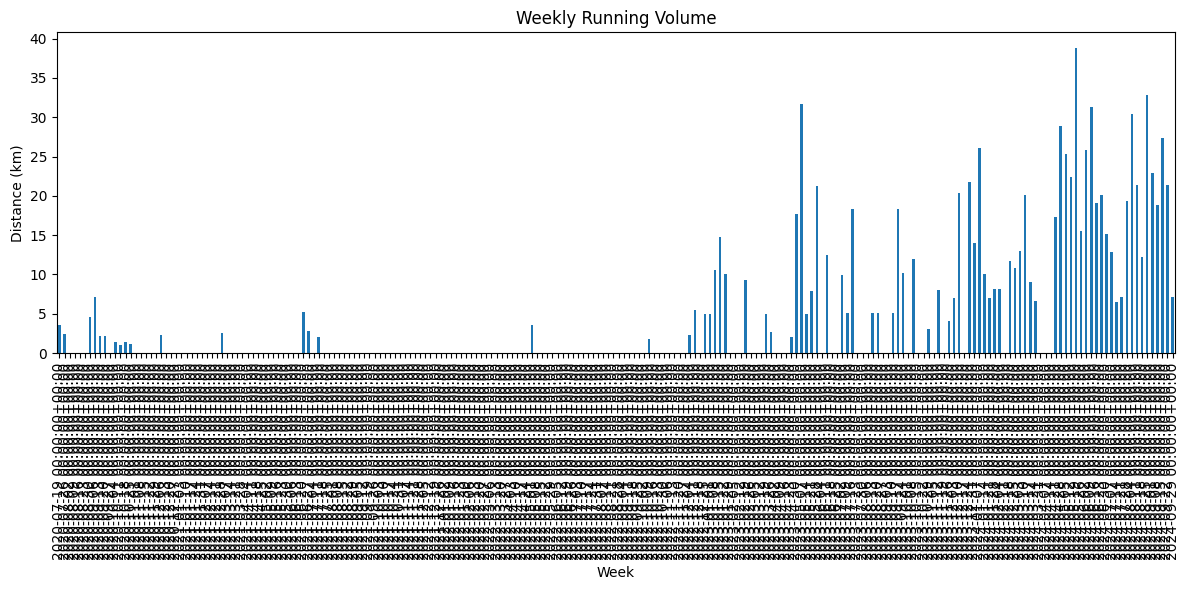

In [38]:
plt.figure(figsize=(12, 6))
weekly_volume.plot(kind='bar')
plt.title('Weekly Running Volume')
plt.xlabel('Week')
plt.ylabel('Distance (km)')
plt.tight_layout()
plt.show()


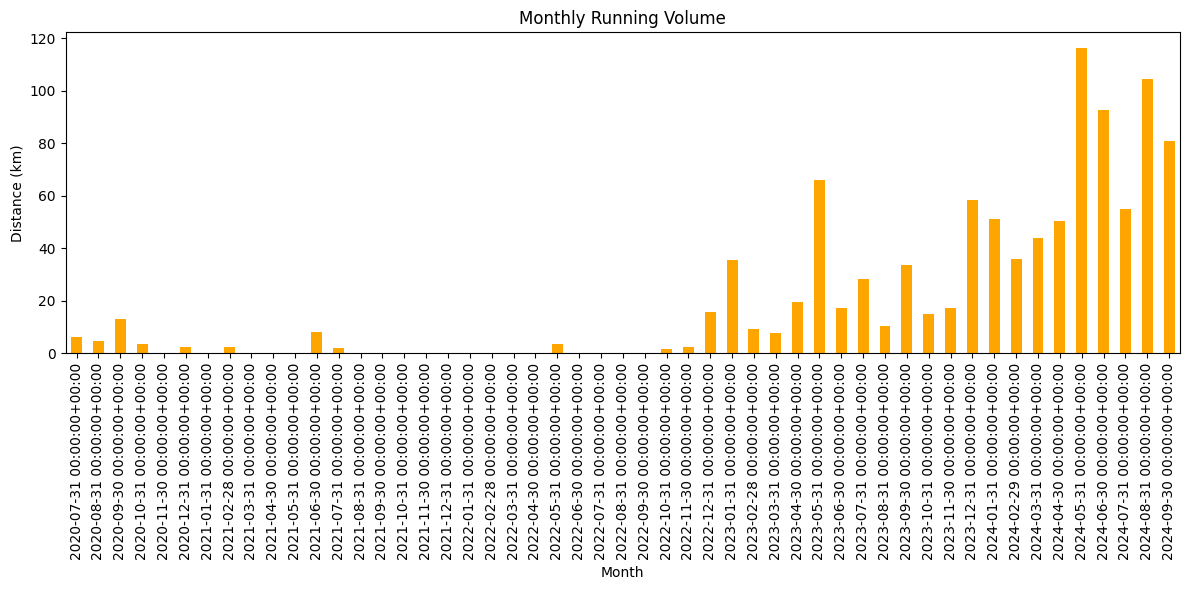

In [39]:
plt.figure(figsize=(12, 6))
monthly_volume.plot(kind='bar', color='orange')
plt.title('Monthly Running Volume')
plt.xlabel('Month')
plt.ylabel('Distance (km)')
plt.tight_layout()
plt.show()


In [40]:
# calculate pace per km
running_df['pace_min_per_km'] = (running_df['moving_time'] / 60) / running_df['distance_km']


In [41]:
# function to find the fastest run for a given distance
def find_fastest_run(distance_km):
    # Filter runs longer than or equal to the target distance
    filtered_runs = running_df[running_df['distance_km'] >= distance_km]
    # Find the run with the lowest pace
    fastest_run = filtered_runs.loc[filtered_runs['pace_min_per_km'].idxmin()]
    return fastest_run

# Example for 5 km
fastest_5k = find_fastest_run(5)
print("Fastest 5K Run:")
print(fastest_5k[['name', 'distance_km', 'moving_time_min', 'pace_min_per_km']])


Fastest 5K Run:
name               Premier 5k (et PR pour l'instant)
distance_km                                   5.0305
moving_time_min                            24.516667
pace_min_per_km                             4.873604
Name: 2020-09-06 14:34:23+00:00, dtype: object


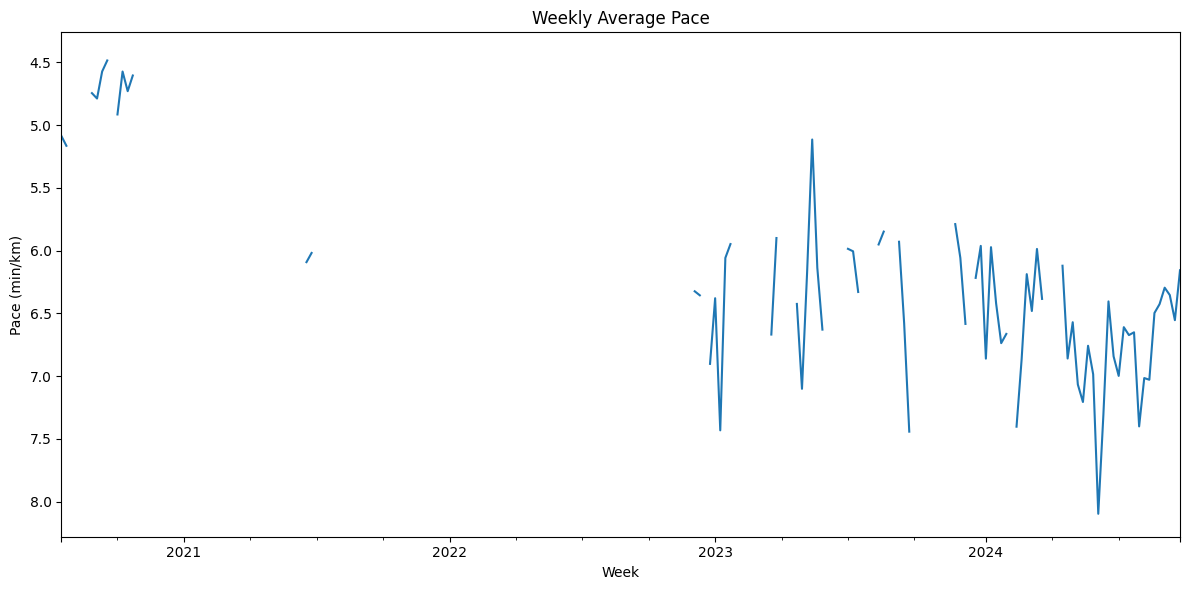

In [42]:
# resample to weekly pace
weekly_pace = running_df.resample('W')['pace_min_per_km'].mean()

# resample to monthly pace
monthly_pace = running_df.resample('M')['pace_min_per_km'].mean()

plt.figure(figsize=(12, 6))
weekly_pace.plot()
plt.title('Weekly Average Pace')
plt.xlabel('Week')
plt.ylabel('Pace (min/km)')
plt.gca().invert_yaxis()  # Lower pace is better
plt.tight_layout()
plt.show()

## NOT REALLY USEFUL

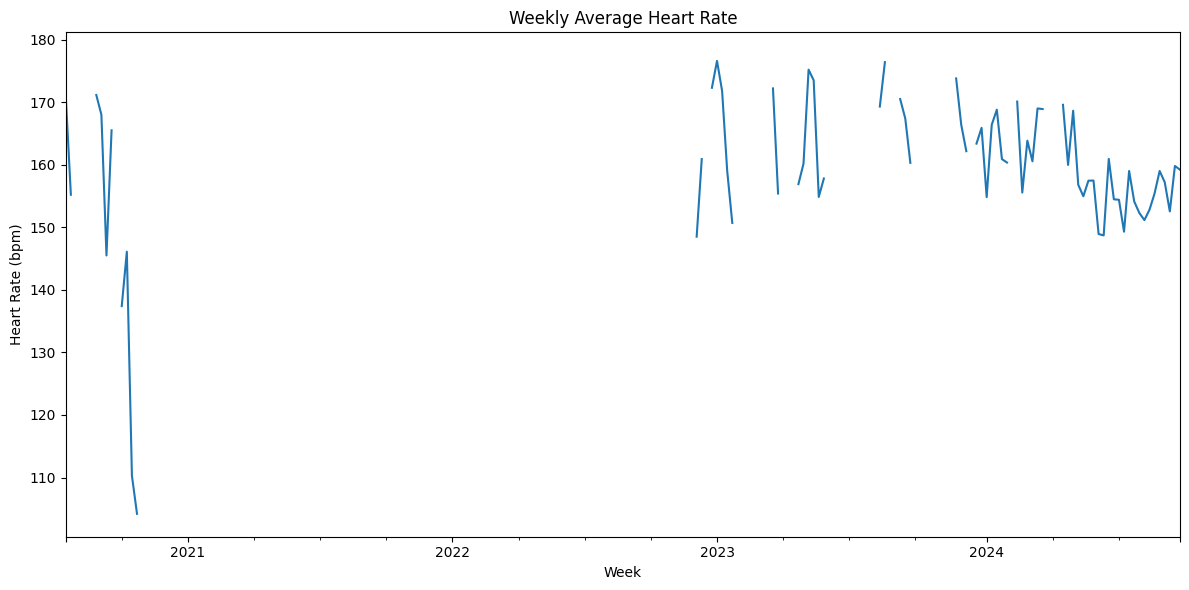

In [43]:
running_df['average_heartrate'].dropna(inplace=True)
weekly_hr = running_df['average_heartrate'].resample('W').mean()

plt.figure(figsize=(12, 6))
weekly_hr.plot()
plt.title('Weekly Average Heart Rate')
plt.xlabel('Week')
plt.ylabel('Heart Rate (bpm)')
plt.tight_layout()
plt.show()
